## **Bond Portfolio and Yield Curve Simulation Using Principal Components Analysis**

#### **Author: Zachary Wright, CFA, FRM | Last Updated: 06/03/25**

**Overview:** In this project, I conduct scenario analyis of the Core Fixed Income SMA model portfolio using Principal Component Analysis to provide a robust interest rate risk analysis on a sample of the strategy and create viable scenarios. Principal Component Analysis allows yield changes to be represented in three simpler non-correlated factors.

**Libraries Used:**

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.preprocessing import StandardScaler
from scipy import stats
import re
from datetime import datetime

To begin, I import top 10 holdings data from the publicly available fact sheet for the Core Fixed Income strategy (as of 3/31/25). The output is shown below in a table with additional relevant statistics such as duration, convexity, and OAS sourced from Fidelity. I have used effective duration as spread duration for the corporate bonds as they are investment grade and this represents a close approximation for demonstration purposes.

In [2]:
df = pd.read_excel("/content/Data_CoreFixedIncome.xlsx",header=0)
df

,Name,Weight,CUSIP,Type,Effective Duration,Effective Convexity,OAS (bps),Spread Duration
0,Government of the United States of America 3.6...,0.0581,91282CHE4,Government,2.795,9.534,NaN,NaN
1,Government of the United States of America 1.8...,0.0565,912828Y95,Government,1.163,1.935,NaN,NaN
2,Government of the United States of America 4.0...,0.0500,91282CHR5,Government,4.597,24.959,NaN,NaN
3,Government of the United States of America 4.0...,0.0414,91282CJW2,Government,3.370,13.585,NaN,NaN
4,Government of the United States of America 4.0...,0.0416,91282CGQ8,Government,4.276,21.604,NaN,NaN
5,Government of the United States of America 2.8...,0.0324,9128284N7,Government,2.826,9.567,NaN,NaN
6,Federal National Mortgage Association 2.125% 2...,0.0491,3135G0K36,Agency MBS,0.906,1.300,5.361,0.906
7,"Lowe's Companies, Inc. 5.0% 15-Apr-2033",0.0253,548661EL7,Corporate,6.330,49.443,78.879,6.330
8,"General Mills, Inc. 4.95% 29-Mar-2033",0.0245,370334CT9,Corporate,6.299,48.880,87.761,6.299
9,American Express Company 4.05% 03-May-2029,0.0249,025816CW7,Corporate,3.541,15.439,28.393,3.541


Additionally, I import the relevant historical treasury yield curve data from Treasury.gov, seen below. The first five rows are displayed. I then trim the data to only focus on specific maturities that are most relevant to the holdings -- the 2 year, 3 year, 5 year, 7 year, and 10 year tenors. The yield curve data covers 5 years and is as of 05/15/25.

In [3]:
yield_curve = pd.read_csv("/content/YieldCurveRates.csv",header=0)
yield_curve.head()

,Date,1 Mo,1.5 Month,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,5/15/2025,4.37,4.38,4.35,4.38,4.43,4.29,4.10,3.96,3.95,4.07,4.25,4.45,4.93,4.91
1,5/14/2025,4.39,4.38,4.36,4.41,4.44,4.30,4.14,4.05,4.05,4.17,4.35,4.53,5.00,4.97
2,5/13/2025,4.39,4.38,4.35,4.41,4.45,4.29,4.11,4.02,4.00,4.12,4.30,4.49,4.97,4.94
3,5/12/2025,4.38,4.37,4.36,4.42,4.45,4.29,4.11,3.98,3.97,4.09,4.27,4.45,4.92,4.89
4,5/9/2025,4.37,4.36,4.34,4.34,4.40,4.28,4.05,3.88,3.85,4.00,4.18,4.37,4.86,4.83


Below I incorporate the PCA dimensionality reduction technique to allow rate changes along the tenors of the yield curve to be represented in 3 independent risk factors. These are commonly called level (uniform change up and down), slope (steepning/flattening), and curvature (butterfly shaped moves) in the literature, which are shown in the graph below. Factor loadings represent sensitivites to the standard deviation shocks in those risk factors.

In [4]:
yield_curve['Date'] = pd.to_datetime(yield_curve['Date'])
yield_curve = yield_curve.sort_values('Date')
yield_changes = yield_curve.set_index('Date').drop(['1.5 Month'],axis=1).diff().dropna()
key_maturities = ['2 Yr','3 Yr','5 Yr','7 Yr','10 Yr']
pca_data = yield_changes[key_maturities]

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)
loadings = pca.components_

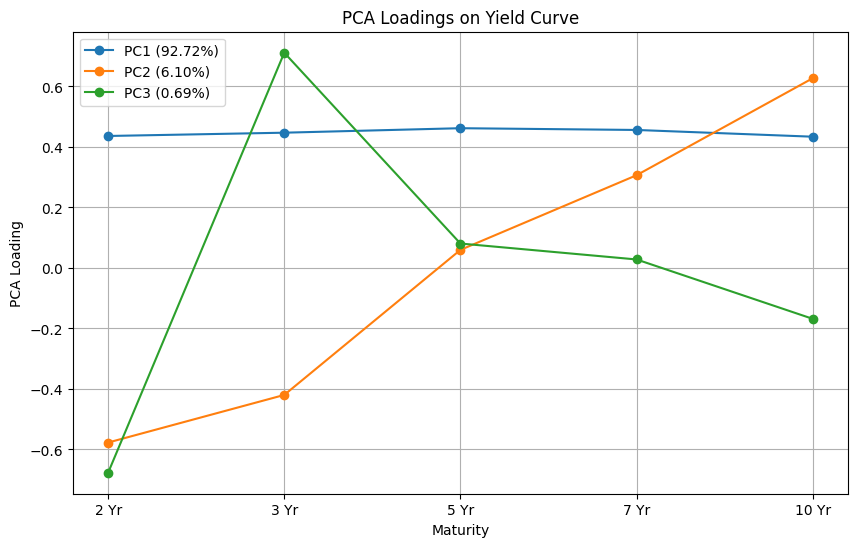

In [6]:
plt.figure(figsize=(10, 6))

for i, component in enumerate(loadings):
    plt.plot(key_maturities, component, marker='o',
             label=f'PC{i+1} ({pca.explained_variance_ratio_[i]:.2%})')

plt.title('PCA Loadings on Yield Curve')
plt.xlabel('Maturity')
plt.ylabel('PCA Loading')
plt.grid(True)
plt.legend()

Here we see that the sum of the principal components (top left) come to almost the total variance explained of yield curve changes -- 99.51% of it. A 2-sigma shock to the slope PC is shown below.

In [7]:
pc2_shock = np.zeros(3)
pc2_shock[1] = 2 * np.std(principal_components[:, 1])
yield_curve_changes2 = pca.inverse_transform(pc2_shock)

print(f"2-year: {yield_curve_changes2[0]*100:.2f} bps")
print(f"3-year: {yield_curve_changes2[1]*100:.2f} bps")
print(f"5-year: {yield_curve_changes2[2]*100:.2f} bps")
print(f"7-year: {yield_curve_changes2[3]*100:.2f} bps")
print(f"10-year: {yield_curve_changes2[4]*100:.2f} bps")

2-year: -63.76 bps
3-year: -46.37 bps
5-year: 6.59 bps
7-year: 33.86 bps
10-year: 69.27 bps


The short-term rates decrease and the longer-term rates increase, simulating a steepening rate environment as desired. Applying these components in tandem, we can create risk scenarios on the portfolio and develop a more robust risk analysis.

As an example, we can envision the following scenarios:

1. Stagflation Scenario (level up, steepening)

2. Policy Error Scenario (level change down, flattening)

3. Soft Landing Scenario (level down, steepening)

Applying a 2-sigma shock to level, we see a rather uniform change as expected.

In [8]:
pc1_shock = np.zeros(3)
pc1_shock[0] = 2 * np.std(principal_components[:, 0])
yield_curve_changes1 = pca.inverse_transform(pc1_shock)

print(f"2-year: {yield_curve_changes1[0]*100:.2f} bps")
print(f"3-year: {yield_curve_changes1[1]*100:.2f} bps")
print(f"5-year: {yield_curve_changes1[2]*100:.2f} bps")
print(f"7-year: {yield_curve_changes1[3]*100:.2f} bps")
print(f"10-year: {yield_curve_changes1[4]*100:.2f} bps")

2-year: 187.86 bps
3-year: 192.54 bps
5-year: 198.93 bps
7-year: 196.44 bps
10-year: 186.85 bps


Case 1: I apply a 2-sigma shock to PC1 (level) and PC2 (slope) to simulate a stagflation scenario.

The shock to level was shown previously, and this is applied simultaneously with the shock to slope.

In [9]:
print(f"Total 2-year change: {(yield_curve_changes1[0]+yield_curve_changes2[0])*100:.2f} bps")
print(f"Total 3-year change: {(yield_curve_changes1[1]+yield_curve_changes2[1])*100:.2f} bps")
print(f"Total 5-year change: {(yield_curve_changes1[2]+yield_curve_changes2[2])*100:.2f} bps")
print(f"Total 7-year change: {(yield_curve_changes1[3]+yield_curve_changes2[3])*100:.2f} bps")
print(f"Total 10-year change: {(yield_curve_changes1[4]+yield_curve_changes2[4])*100:.2f} bps")

Total 2-year change: 124.11 bps
Total 3-year change: 146.17 bps
Total 5-year change: 205.53 bps
Total 7-year change: 230.29 bps
Total 10-year change: 256.12 bps


I now simulate a bear steepener scenario below, which causes the 10-year to rise by a target amount of 100 bps. As we are using PCA, the other tenors rise  or fall depending on the captured correlation structure as desired. The adjusted table and a graph is then shown with the changes.

In [10]:
target_bps = 100
daily_yield_changes = pca.inverse_transform(pc2_shock)
scaling_factor = target_bps / daily_yield_changes[4] / 100

scenario_moves = daily_yield_changes * scaling_factor

print(f"Bear steepener scenario (bps):")
for i, tenor in enumerate(['2-year', '3-year', '5-year', '7-year', '10-year']):
    print(f"{tenor}: {scenario_moves[i]*100:.2f}")

Bear steepener scenario (bps):
2-year: -92.04
3-year: -66.94
5-year: 9.52
7-year: 48.88
10-year: 100.00


Here is our new yield curve, with the plotted change graphed below:

In [15]:
yield_changes2 = yield_curve.drop(['Date'],axis=1).drop(['1.5 Month'],axis=1).dropna()
current_curve = yield_changes2[key_maturities]
new_curve = current_curve.add(scenario_moves)
new_curve.head(1)

,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr
92,3.329633,3.620589,4.475192,4.958758,5.57


In [12]:
current_curve_t = current_curve.transpose()
new_curve_t = new_curve.transpose()

<ipython-input-13-5c7ba0695274>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(m, (current_yields[i] + new_curve.iloc[-1][i])/2),


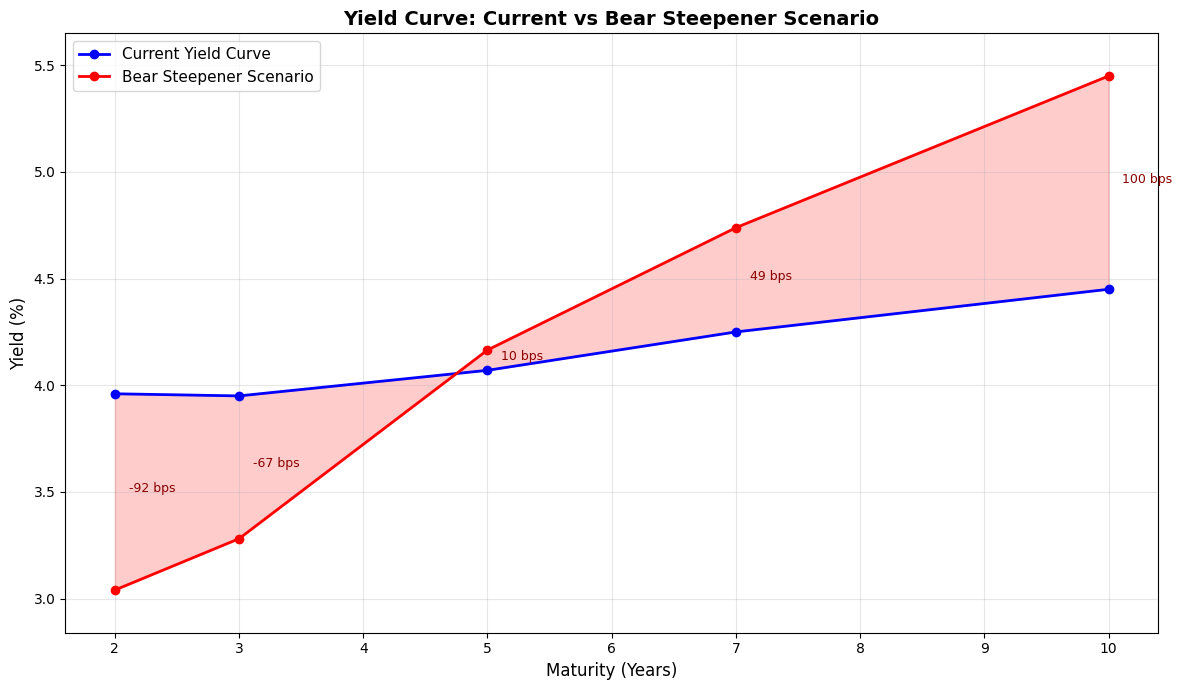

In [13]:
latest_date = current_curve_t.index[-1]  # Most recent date
current_yields = current_curve.iloc[-1]  # Latest yield curve data
maturities = [2, 3, 5, 7, 10]

plt.figure(figsize=(12, 7))
plt.plot(maturities, current_yields, 'b-o', linewidth=2, label='Current Yield Curve')
plt.plot(maturities, new_curve.iloc[-1], 'r-o', linewidth=2, label='Bear Steepener Scenario')

plt.fill_between(maturities, current_yields, new_curve.iloc[-1], alpha=0.2, color='red')

for i, m in enumerate(maturities):
    change = scenario_moves[i] * 100
    plt.annotate(f"{change:.0f} bps",
                 xy=(m, (current_yields[i] + new_curve.iloc[-1][i])/2),
                 xytext=(10, 0), textcoords="offset points",
                 fontsize=9, color='darkred')

plt.xlabel('Maturity (Years)', fontsize=12)
plt.ylabel('Yield (%)', fontsize=12)
plt.title('Yield Curve: Current vs Bear Steepener Scenario', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

min_y = min(current_yields.min(), new_curve.iloc[-1].min()) - 0.2
max_y = max(current_yields.max(), new_curve.iloc[-1].max()) + 0.2
plt.ylim(min_y, max_y)

plt.tight_layout()
plt.show()

We have successfully simulated the appropriate yield curve movement. Now I will reprice the securities in the portfolio to wrap up the bear steepener scenario. Without key rate duration data, I use the effective duration as an approximation of which tenor yield changes in the scenario to apply. In practice, using key rate durations would provide the most accurate price impact on the portfolio, as effective duration assumes parallel yield curve shifts.

I also assume and utilize a negative correlation of 0.3 for investment grade spread changes to yield curve rate changes since the maturities of the corporates are around 5 years or above. This is applied to the corporate bonds' approximated spread duration for a complete price impact calculation. In practice these correlations can be estimated directly with appropriate spread data.

In [14]:
scenario_moves_bps = np.array([-92.04, -66.94, 9.52, 48.88, 100.00])
scenario_maturities = [2, 3, 5, 7, 10]

def extract_maturity_date(name):
    date_pattern = r'\d{1,2}-[A-Za-z]{3}-\d{4}'
    match = re.search(date_pattern, name)
    if match:
        return pd.to_datetime(match.group(), format='%d-%b-%Y')
    return None

df['Maturity Date'] = df['Name'].apply(extract_maturity_date)
current_date = pd.Timestamp.now()
df['Years to Maturity'] = (df['Maturity Date'] - current_date).dt.days / 365

def get_yield_change(years):
    if years <= scenario_maturities[0]:
        return scenario_moves_bps[0]
    elif years >= scenario_maturities[-1]:
        return scenario_moves_bps[-1]

    for i in range(len(scenario_maturities)-1):
        if scenario_maturities[i] <= years <= scenario_maturities[i+1]:
            weight = (years - scenario_maturities[i]) / (scenario_maturities[i+1] - scenario_maturities[i])
            return scenario_moves_bps[i] * (1-weight) + scenario_moves_bps[i+1] * weight
    return 0

df['Yield Change (bps)'] = df['Years to Maturity'].apply(get_yield_change)
df['Yield Change (%)'] = df['Yield Change (bps)'] / 10000

df['Price Impact (%)'] = -df['Effective Duration'] * df['Yield Change (%)'] * 100 + \
                         0.5 * df['Effective Convexity'] * (df['Yield Change (%)']**2) * 100

for i, row in df.iterrows():
    if row['Type'] == 'Corporate':
        spread_beta = -0.3
        spread_change = spread_beta * (scenario_moves_bps[-1] / 10000)
        spread_duration = row['Spread Duration']
        spread_impact = -spread_duration * spread_change * 100
        df.at[i, 'Price Impact (%)'] += spread_impact

original_weights = df['Weight'].values
rescaled_weights = original_weights / original_weights.sum()
df['Rescaled Weight'] = rescaled_weights

df['Weighted Impact (%)'] = df['Rescaled Weight'] * df['Price Impact (%)']
portfolio_impact = df['Weighted Impact (%)'].sum()

print(f"Total Portfolio Impact: {portfolio_impact:.2f}%")

df

Total Portfolio Impact: 0.59%


,Name,Weight,CUSIP,Type,Effective Duration,Effective Convexity,OAS (bps),Spread Duration,Maturity Date,Years to Maturity,Yield Change (bps),Yield Change (%),Price Impact (%),Rescaled Weight,Weighted Impact (%)
0,Government of the United States of America 3.6...,0.0581,91282CHE4,Government,2.795,9.534,NaN,NaN,2028-05-31,2.991781,-67.146301,-0.006715,1.898232,0.143883,0.273123
1,Government of the United States of America 1.8...,0.0565,912828Y95,Government,1.163,1.935,NaN,NaN,2028-07-31,3.158904,-60.865096,-0.006087,0.711445,0.139921,0.099546
2,Government of the United States of America 4.0...,0.0500,91282CHR5,Government,4.597,24.959,NaN,NaN,2030-07-31,5.158904,12.647233,0.001265,-0.579397,0.123824,-0.071743
3,Government of the United States of America 4.0...,0.0414,91282CJW2,Government,3.370,13.585,NaN,NaN,2029-01-31,3.663014,-41.592986,-0.004159,1.413435,0.102526,0.144914
4,Government of the United States of America 4.0...,0.0416,91282CGQ8,Government,4.276,21.604,NaN,NaN,2030-02-28,4.739726,-0.430274,-0.000043,0.018401,0.103021,0.001896
5,Government of the United States of America 2.8...,0.0324,9128284N7,Government,2.826,9.567,NaN,NaN,2028-05-15,2.947945,-68.246575,-0.006825,1.950928,0.080238,0.156538
6,Federal National Mortgage Association 2.125% 2...,0.0491,3135G0K36,Agency MBS,0.906,1.300,5.361,0.906,2026-04-24,0.887671,-92.040000,-0.009204,0.839389,0.121595,0.102065
7,"Lowe's Companies, Inc. 5.0% 15-Apr-2033",0.0253,548661EL7,Corporate,6.330,49.443,78.879,6.330,2033-04-15,7.868493,63.679123,0.006368,-2.031642,0.062655,-0.127292
8,"General Mills, Inc. 4.95% 29-Mar-2033",0.0245,370334CT9,Corporate,6.299,48.880,87.761,6.299,2033-03-29,7.821918,62.885479,0.006289,-1.974806,0.060674,-0.119819
9,American Express Company 4.05% 03-May-2029,0.0249,025816CW7,Corporate,3.541,15.439,28.393,3.541,2029-05-03,3.915068,-31.956932,-0.003196,2.201778,0.061664,0.135771


### Preliminary Conclusions
Provided the assumptions communicated in this project, and as the bulk of the rate increases occur at the 5-year and above in our simulation, the total portfolio impact is  estimated to be a price increase of 0.56% for this set of top 10 holdings. This implies that the portfolio would hold in scenarios where the fed cuts rates and economic growth and inflation expectations rise, at least initially.

### Potential Further Applications
- Implementation of Nelson-Siegel model to determine cheap or richly traded maturities across the US treasury yield curve or municipal yield curve tenors (forecasting using regression of principal components)
- Gauging principal component factor loadings to create portfolio weightings that hedge against certain moves, e.g. slope changes if faced with a steepening scenario
- Run a Monte Carlo analysis on sampled principal components to compute portfolio Value-at-Risk, Expected Shortfall, at 95th, 99th, etc., percentile for stress testing purposes